Se genera para cada mes del archivo ERA5

**Codigo nuevo para cada mes**

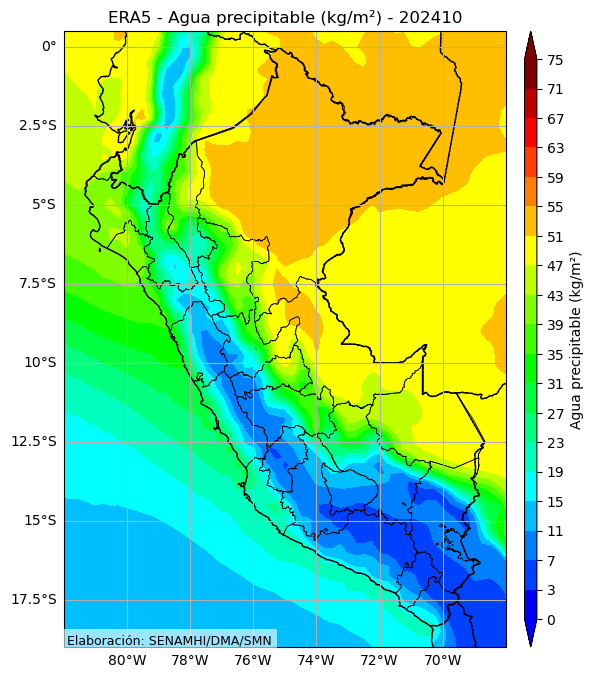

In [1]:
import numpy as np
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapefile
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Define la fecha inicial y crea la ruta al archivo GRIB
FECHA_INICIAL = 202410
ruta_archivo = f'/scratch/DMA/SMN/CLIMA/ERA5/SURFACE/flx_era5_{FECHA_INICIAL}.grib'
ruta_shapefile = '/scratch/shape/PER/DEPARTAMENTOS.shp'

# Abre el archivo GRIB usando cfgrib
ds = cfgrib.open_dataset(ruta_archivo)

# Extrae las variables necesarias
lons = ds.longitude.values
lats = ds.latitude.values
time = ds.time.values  # Un único valor numpy.datetime64

# Extrae la variable de agua precipitable (kg/m²)
prw = ds.tcw.values  # Asumiendo que tcw es agua precipitable

# Crear un mapa de colores degradado con colores utilizados en meteorología
colors = [
    "#0000ff", "#0040ff", "#0080ff", "#00bfff", "#00ffff",
    "#00ffbf", "#00ff80", "#00ff40", "#00ff00", "#40ff00",
    "#80ff00", "#bfff00", "#ffff00", "#ffbf00", "#ff8000",
    "#ff4000", "#ff0000", "#bf0000", "#800000"
]
cmap = ListedColormap(colors)

# Crear los límites del mapa de colores entre 0 y 75
levels = np.linspace(0, 75, len(colors) + 1)
norm = BoundaryNorm(levels, cmap.N)

# Cargar los shapefiles de Perú usando `pyshp`
sf = shapefile.Reader(ruta_shapefile)

# Extraer la fecha en formato MMYYYY
current_date = pd.to_datetime(time).strftime('%Y%m')

# Configura el mapa
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-82, -68, -19, 0.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Añadir los límites de los países con líneas más visibles
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black', linewidth=1)

# Añadir los shapefiles de Perú con líneas continuas y más delgadas
for shape_rec in sf.shapeRecords():
    shape = shape_rec.shape
    points = shape.points
    parts = shape.parts
    parts.append(len(points))  # Add the last point to close the loop
    for i in range(len(parts) - 1):
        ax.plot(
            [points[j][0] for j in range(parts[i], parts[i + 1])],
            [points[j][1] for j in range(parts[i], parts[i + 1])],
            transform=ccrs.PlateCarree(),
            color='black',
            linewidth=0.5
        )

# Añade las líneas de contorno para el agua precipitable
contour = ax.contourf(lons, lats, prw, levels=levels, cmap=cmap, norm=norm, extend='both')

# Añade la barra de color
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('Agua precipitable (kg/m²)')
cbar.set_ticks(levels)
cbar.set_ticklabels([str(int(level)) for level in levels])

# Añade un título con la fecha
plt.title(f'ERA5 - Agua precipitable (kg/m²) - {current_date}', y=1.0)

# Añade formato a los ejes y etiquetas
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Añadir la leyenda de texto en la parte inferior derecha
ax.text(0.47, -0.0002, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=9, color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Guarda el gráfico con alta resolución en la carpeta especificada
output_filename = f'/scratch/DMA/SMN/CLIMA/web_figuras/monitoreo/mensual/era5_{current_date}_pwat_per.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Muestra el gráfico
plt.show()

# Cierra la figura para liberar memoria
plt.close(fig)

# Cierra el dataset
ds.close()
